In [1]:
from google.colab import drive
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [2]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/Modified_SQL_Dataset_preprocessed.csv'
data = pd.read_csv(data_path)

print(data.head())

# Fill NaN values (if any) and ensure the 'Query' column is string format
preprocessed_query = data['Query'].fillna('').apply(str)

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize with bigrams (1, 2) and limit features if desired
count_vect = CountVectorizer(ngram_range=(1, 2), min_df=10, max_features=5000)
bigram_counts = count_vect.fit_transform(preprocessed_query)

# Verify the vectorized data
print("The shape of our text BOW vectorizer:", bigram_counts.shape)
feature_names = count_vect.get_feature_names_out()
print(f"Feature names (first 10): {feature_names[:10]}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(bigram_counts, data['Label'], test_size=0.2, random_state=42)



Mounted at /content/drive
                                               Query  Label
0                                      pg sleep time      1
1  create user name identified pass123 temporary ...      1
2  1 utl inaddr get host address select distinct ...      1
3      select user id 1 1 1 union select 1 version 1      1
4        select user id 1 1 union select 1 version 1      1
The shape of our text BOW vectorizer: (30919, 2931)
Feature names (first 10): ['01' '01 1996' '06' '06 15' '07' '07 01' '07 31' '09' '09 34' '0x28']


In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**SVM**

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score: 0.9475237517687487
Best Parameters: {'C': 10, 'kernel': 'rbf'}
    param_C param_kernel  mean_test_score  std_test_score
7      10.0          rbf         0.947524        0.003081
4       1.0          rbf         0.944289        0.003781
3       1.0       linear         0.939883        0.002552
11    100.0         poly         0.937336        0.003392
0       0.1       linear         0.936446        0.003355
6      10.0       linear         0.933455        0.004116
10    100.0          rbf         0.932646        0.004661
9     100.0       linear         0.922660        0.005112
1       0.1          rbf         0.920760        0.003409
8      10.0         poly         0.919264        0.003218
5       1.0         poly         0.892905        0.002584
2       0.1         poly         0.824015        0.006080


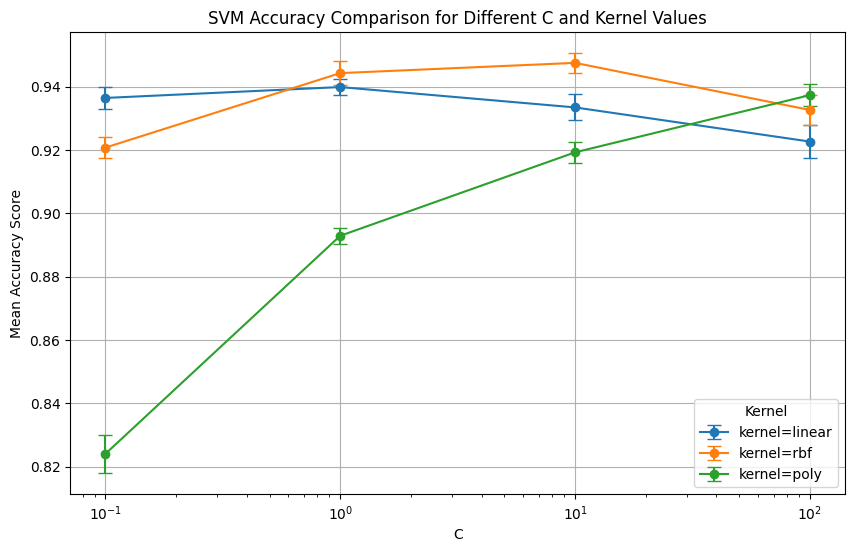

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3893
           1       1.00      0.87      0.93      2291

    accuracy                           0.95      6184
   macro avg       0.96      0.93      0.95      6184
weighted avg       0.95      0.95      0.95      6184



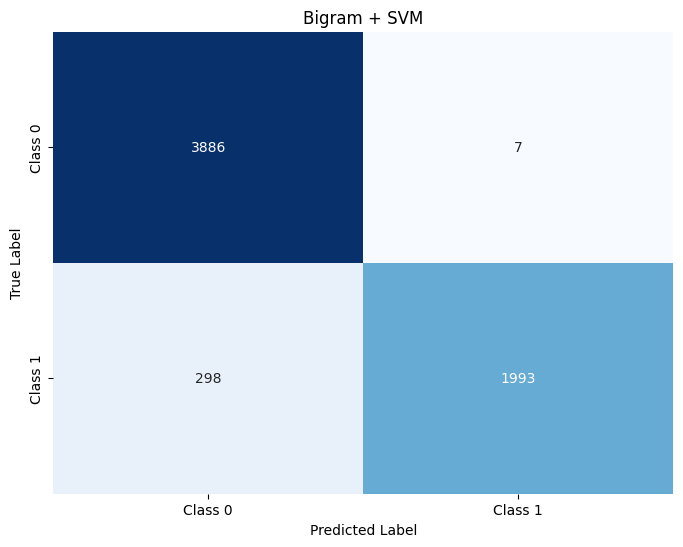

In [ ]:
svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
}
svm = SVC()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=svm, param_grid=svm_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

# Summarize grid search results
svm_results = pd.DataFrame(grid.cv_results_)
svm_results_summary = svm_results[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score']]
svm_results_summary_sorted = svm_results_summary.sort_values(by='mean_test_score', ascending=False)
print(svm_results_summary_sorted)

# Plot the grid search results for SVM
plt.figure(figsize=(10, 6))
for kernel in ['linear', 'rbf', 'poly']:
    subset = svm_results_summary[svm_results_summary['param_kernel'] == kernel]
    plt.errorbar(subset['param_C'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'kernel={kernel}')
plt.xlabel('C')
plt.ylabel('Mean Accuracy Score')
plt.title('SVM Accuracy Comparison for Different C and Kernel Values')
plt.xscale('log')  # Use logarithmic scale for C to better visualize differences
plt.legend(title='Kernel')
plt.grid(True)
plt.show()

# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Bigram + SVM')
plt.show()

**Naive Bayes**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.9398019001414999
Best Parameters: {'alpha': 0.01, 'fit_prior': False}
   param_alpha  param_fit_prior  mean_test_score  std_test_score
1         0.01            False         0.939802        0.003064
3         0.10            False         0.939802        0.003064
5         1.00            False         0.939600        0.003143
7        10.00            False         0.938589        0.002854
6        10.00             True         0.937861        0.003251
0         0.01             True         0.936931        0.002856
2         0.10             True         0.936931        0.002856
4         1.00             True         0.936810        0.002937


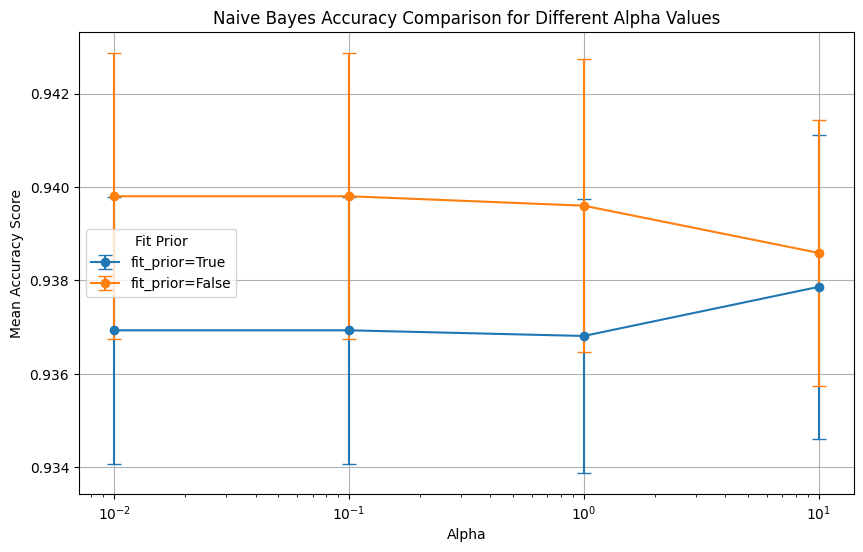

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3893
           1       0.99      0.86      0.92      2291

    accuracy                           0.94      6184
   macro avg       0.95      0.93      0.94      6184
weighted avg       0.95      0.94      0.94      6184



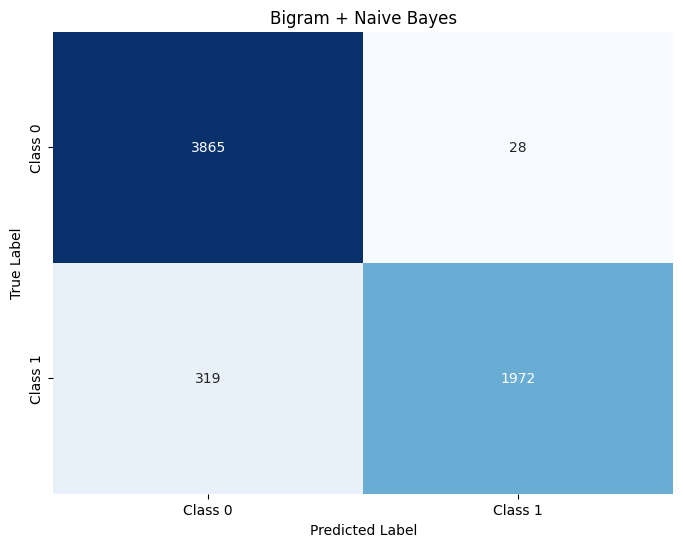

In [ ]:
nb_parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}
nb = MultinomialNB()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=nb, param_grid=nb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

# Summarize grid search results
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_alpha', 'param_fit_prior', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
print(results_summary_sorted)

# Plot the grid search results for Naive Bayes
plt.figure(figsize=(10, 6))
for fit_prior in [True, False]:
    subset = results_summary[results_summary['param_fit_prior'] == fit_prior]
    plt.errorbar(subset['param_alpha'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'fit_prior={fit_prior}')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy Score')
plt.title('Naive Bayes Accuracy Comparison for Different Alpha Values')
plt.xscale('log')  # Use logarithmic scale for alpha to better visualize differences
plt.legend(title='Fit Prior')
plt.grid(True)
plt.show()

# Predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Bigram + Naive Bayes')
plt.show()

**KNN**

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best Score: 0.8659793814432991
Best Parameters: {'n_neighbors': 6}
    param_n_neighbors  mean_test_score  std_test_score
3                   6         0.865979        0.009775
2                   5         0.852678        0.009273
5                   8         0.852638        0.010548
7                  10         0.841237        0.010626
4                   7         0.839175        0.009688
1                   3         0.836143        0.006303
6                   9         0.834122        0.008950
9                  12         0.832585        0.012273
11                 14         0.825955        0.013627
8                  11         0.825874        0.009396
10                 13         0.820012        0.011196
13                 16         0.819810        0.012707
15                 18         0.815120        0.011581
12                 15         0.814959        0.010954
14                 17         0.810956        

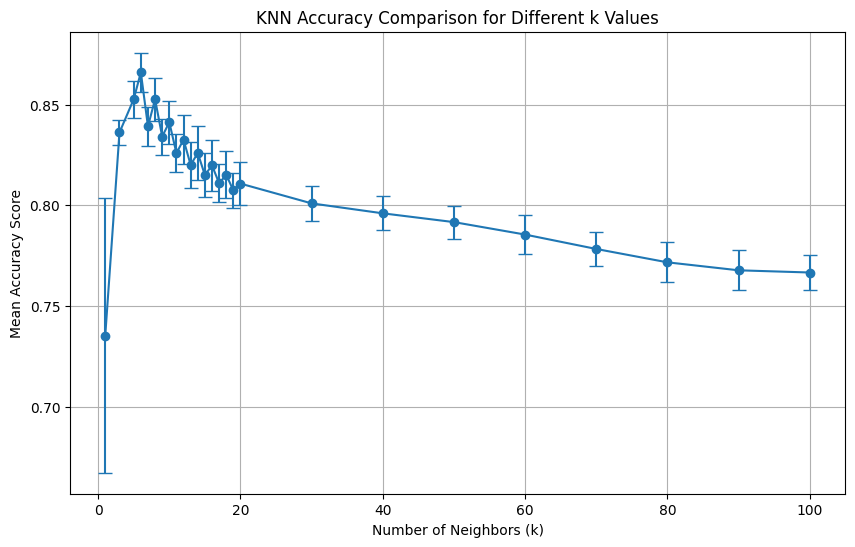

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3893
           1       0.80      0.88      0.84      2291

    accuracy                           0.87      6184
   macro avg       0.86      0.88      0.87      6184
weighted avg       0.88      0.87      0.88      6184



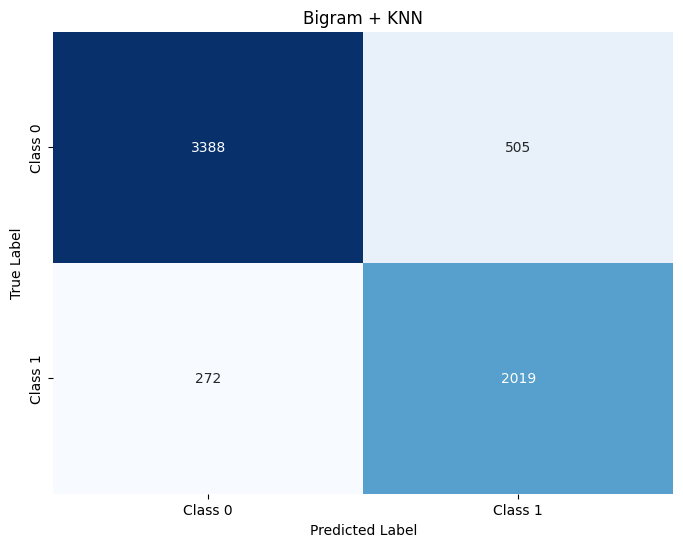

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the KNN model and hyperparameter grid
knn_parameters = {'n_neighbors': [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=knn, param_grid=knn_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

# Summarize grid search results
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_n_neighbors', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
print(results_summary_sorted)

# Plot mean accuracy for different k values
plt.figure(figsize=(10, 6))
plt.errorbar(results_summary['param_n_neighbors'], results_summary['mean_test_score'], yerr=results_summary['std_test_score'], fmt='-o', capsize=5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy Score')
plt.title('KNN Accuracy Comparison for Different k Values')
plt.grid(True)
plt.show()

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Bigram + KNN')
plt.show()


**XGBoost**

In [6]:

from xgboost import XGBClassifier

xgb_parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

results = pd.DataFrame(grid.cv_results_)
results_summary = results[['param_n_estimators', 'param_max_depth', 'param_learning_rate',
                           'param_subsample', 'param_colsample_bytree', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
results_summary_sorted



Fitting 5 folds for each of 405 candidates, totalling 2025 fits


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:33] WARNING: /worksp

Best Score: 0.9457853244390539
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,mean_test_score,std_test_score
269,200,7,0.20,1.0,0.8,0.945785,0.002891
134,200,7,0.20,1.0,0.7,0.945745,0.002872
403,200,7,0.20,0.8,1.0,0.945704,0.002817
119,200,5,0.20,1.0,0.7,0.945704,0.002909
268,200,7,0.20,0.8,0.8,0.945664,0.002894
...,...,...,...,...,...,...,...
300,10,7,0.01,0.7,1.0,0.632464,0.000081
301,10,7,0.01,0.8,1.0,0.632464,0.000081
302,10,7,0.01,1.0,1.0,0.632464,0.000081
32,10,7,0.01,1.0,0.7,0.632464,0.000081


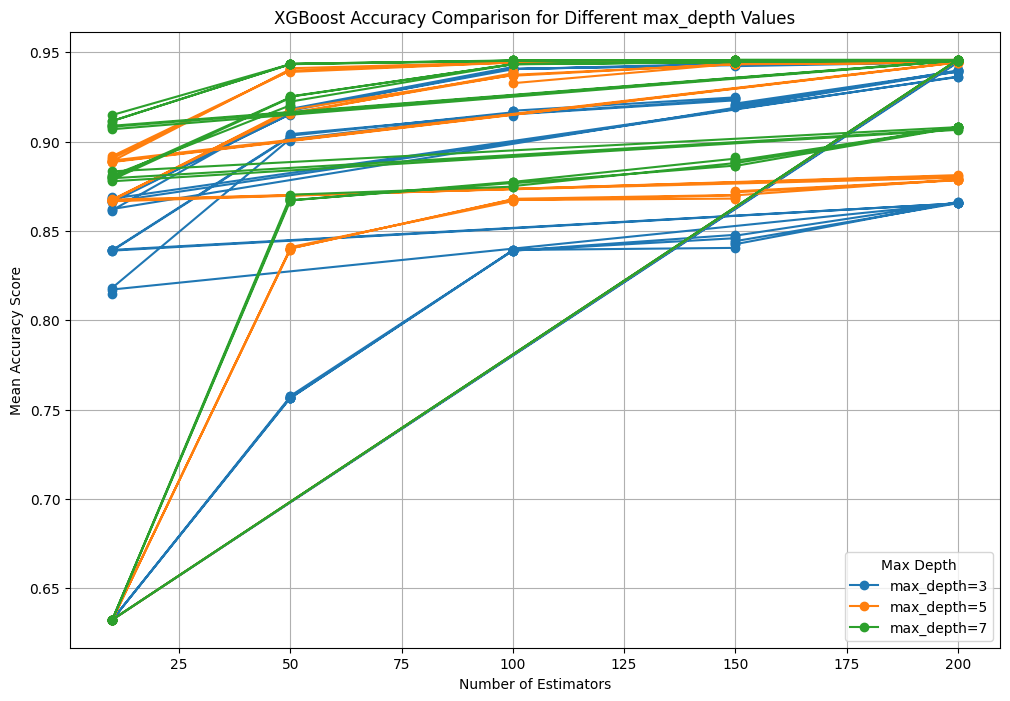

In [7]:
plt.figure(figsize=(12, 8))
for depth in xgb_parameters['max_depth']:
    subset = results_summary[results_summary['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], '-o', label=f'max_depth={depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('XGBoost Accuracy Comparison for Different max_depth Values')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3893
           1       1.00      0.86      0.93      2291

    accuracy                           0.95      6184
   macro avg       0.96      0.93      0.94      6184
weighted avg       0.95      0.95      0.95      6184



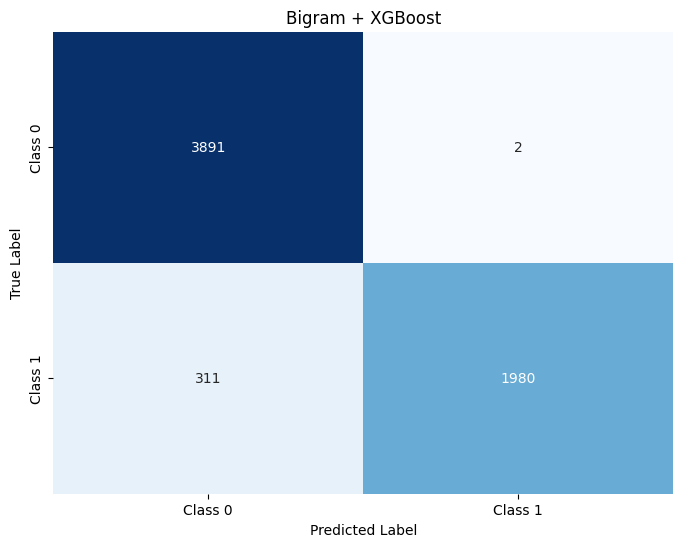

In [10]:
y_pred = grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Bigram + XGBoost')
plt.show()

# Chạy thực nghiệm

In [11]:
from xgboost import XGBClassifier
import joblib

# Best parameters
xgb = XGBClassifier(
    colsample_bytree=0.7,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=150,
    subsample=1.0
)

xgb.fit(X_train, y_train)

# Save the model as a .pkl file
joblib.dump(xgb, 'xgb_model.pkl')
print("Model saved as 'xgb_model.pkl'")


Model saved as 'xgb_model.pkl'


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Best parameters for KNN
knn = KNeighborsClassifier(n_neighbors=3)


knn.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(knn, 'knn_model.pkl')
print("Model saved as 'knn_model.pkl'")

Model saved as 'knn_model.pkl'


In [ ]:
from sklearn.svm import SVC
import joblib

# Best parameters for SVM
svm = SVC(C=10, kernel='rbf', probability=True)

# Train the SVM model on the training data
svm.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(svm, 'svm_model.pkl')
print("Model saved as 'svm_model.pkl'")


Model saved as 'svm_model.pkl'
